# Visualization notebook

In [166]:
## Imports
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import glob
import pickle
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cpf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seawater as sw
import cmocean.cm as cmo
from scipy import integrate
from scipy.interpolate import griddata
import sys
import gsw

sys.path.insert(0,'/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Slocum-AD2CP/src/analysis')
from analysis import gsw_rho, profile_mld, dist_from_lat_lon



## because pandas is stupid/I'm bad at coding
class ChainedAssignent:
    def __init__(self, chained=None):
        acceptable = [None, 'warn', 'raise']
        assert chained in acceptable, "chained must be in " + str(acceptable)
        self.swcw = chained

    def __enter__(self):
        self.saved_swcw = pd.options.mode.chained_assignment
        pd.options.mode.chained_assignment = self.swcw
        return self

    def __exit__(self, *args):
        pd.options.mode.chained_assignment = self.saved_swcw

## Load total dataframe (this takes ~30 seconds)

In [2]:
tot_transect_df = pd.read_csv('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/AOML_data_subset_transects.csv')

In [3]:
tot_transect_df

,ctd_time,ctd_pressure,aanderaa4831_dissolved_oxygen_shifted,downs,longitude,latitude,temperature,salinity,density,aanderaa4831_dissolved_oxygen,du,dv,su,sv,time_shift,transect_number,deployment_name
0,2015-02-09 08:21:40,1.278298,192.300091,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,1,SG609-M02FEB2015
1,2015-02-09 08:21:49,1.321579,192.386667,1.0,-67.465350,17.555617,26.974641,NaN,NaN,NaN,0.003769,-0.047933,-1.881567,-16.145390,49,1,SG609-M02FEB2015
2,2015-02-09 08:21:59,1.778545,192.418361,1.0,-67.465350,17.555612,26.975472,NaN,NaN,NaN,0.003769,-0.047933,-1.881567,-16.145390,49,1,SG609-M02FEB2015
3,2015-02-09 08:22:18,3.029667,192.387976,1.0,-67.465349,17.555604,26.984981,NaN,NaN,NaN,0.003769,-0.047933,-1.881567,-16.145390,49,1,SG609-M02FEB2015
4,2015-02-09 08:22:28,4.100253,192.504311,1.0,-67.465302,17.555602,26.994143,NaN,NaN,NaN,0.003769,-0.047933,-1.881567,-16.145390,49,1,SG609-M02FEB2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10807892,2022-07-07 14:08:22,13.041327,241.704636,0.0,-65.033142,17.011794,28.242144,34.262031,1021.762859,241.776639,-0.081773,0.104027,-35.936865,19.686799,52,117,SG678-M12JUL2022
10807893,2022-07-07 14:08:31,11.730388,241.883389,0.0,-65.033147,17.011787,28.254553,34.259990,1021.757259,241.690682,-0.081773,0.104027,-35.936865,19.686799,52,117,SG678-M12JUL2022
10807894,2022-07-07 14:08:42,10.016299,242.055362,0.0,-65.033152,17.011778,28.258000,34.259422,1021.755703,241.742825,-0.081773,0.104027,-35.936865,19.686799,52,117,SG678-M12JUL2022
10807895,2022-07-07 14:08:52,8.443124,241.966350,0.0,-65.033155,17.011770,28.257050,34.258350,1021.755209,241.782111,-0.081773,0.104027,-35.936865,19.686799,52,117,SG678-M12JUL2022


## Split transects into north and south

In [4]:
north_transect_df = tot_transect_df[(tot_transect_df.latitude.values > 18.35)]
south_transect_df = tot_transect_df[(tot_transect_df.latitude.values < 18.35)]

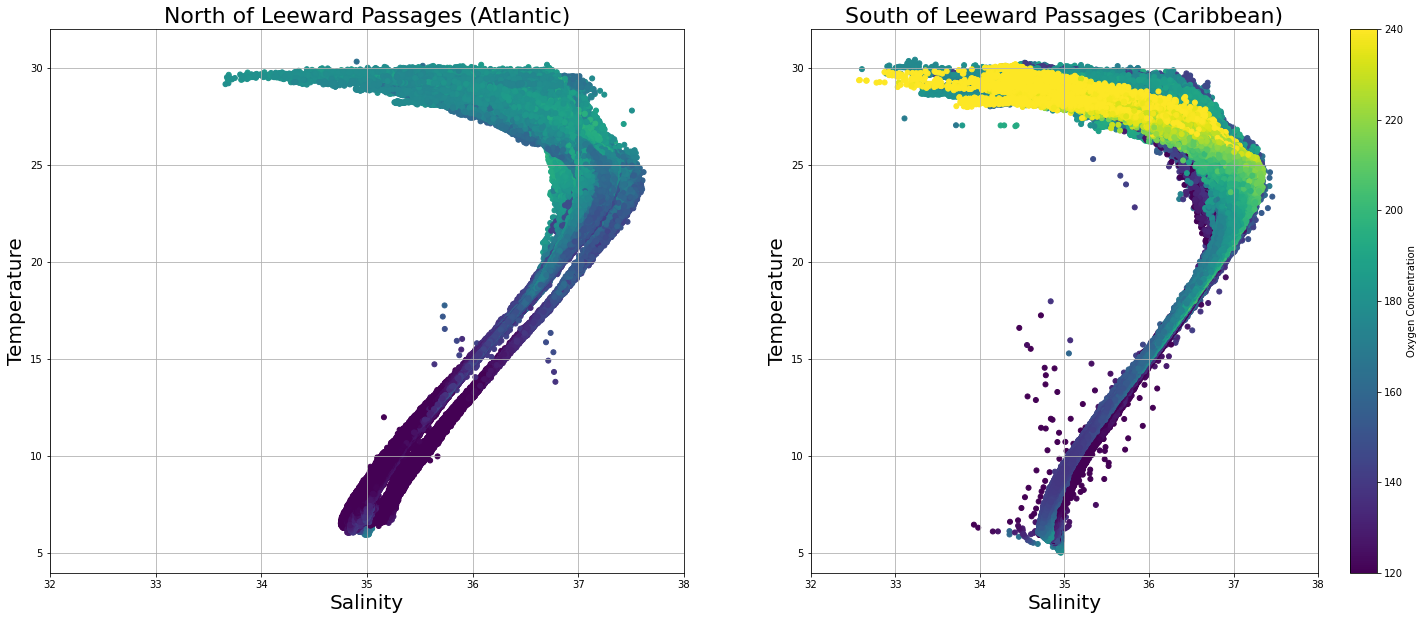

In [5]:
fig, ax = plt.subplots(1,2, figsize=(25,10))


######### Plot settings #########
## Plot ever increment points
increment = 10
## Font size
font_size = 20
## Title size
title_size = 22
## markersize
markersize = 25
## colorbar range
vmin = 120
vmax = 240

ax[0].scatter(north_transect_df.salinity.values[::increment],north_transect_df.temperature.values[::increment],c=north_transect_df.aanderaa4831_dissolved_oxygen_shifted.values[::increment],vmin=vmin,vmax=vmax,s=markersize)
ax[0].set_xlim(32,38)
ax[0].set_ylim(4,32)
ax[0].set_xlabel('Salinity', size=font_size)
ax[0].set_ylabel('Temperature', size=font_size)
ax[0].set_title('North of Leeward Passages (Atlantic)', size=title_size)
ax[0].grid()

im = ax[1].scatter(south_transect_df.salinity.values[::increment],south_transect_df.temperature.values[::increment],c=south_transect_df.aanderaa4831_dissolved_oxygen_shifted.values[::increment],vmin=vmin,vmax=vmax,s=markersize)
ax[1].set_xlim(32,38)
ax[1].set_ylim(4,32)
ax[1].set_xlabel('Salinity', size=font_size)
ax[1].set_ylabel('Temperature', size=font_size)
ax[1].set_title('South of Leeward Passages (Caribbean)', size=title_size)
ax[1].grid()

fig.colorbar(im, label='Oxygen Concentration')


Text(0.5, 1.0, 'AOML Gliders (2015-2022) Subset for Caribbean Water Mass Analysis')

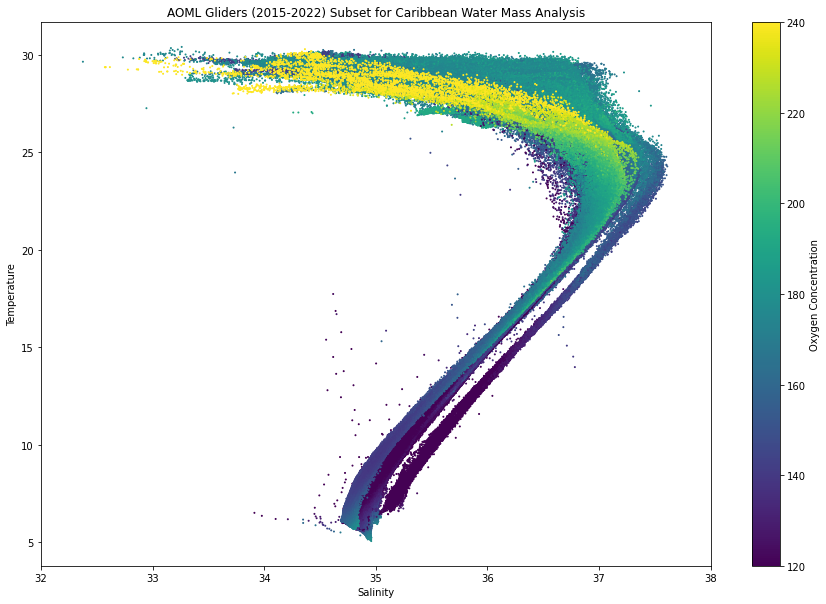

In [7]:
increment = 10


plt.figure(figsize=(15,10))
plt.scatter(tot_transect_df.salinity.values[::10],tot_transect_df.temperature.values[::10],c=tot_transect_df.aanderaa4831_dissolved_oxygen_shifted.values[::10],vmin=120,vmax=240,s=1)
plt.colorbar(label='Oxygen Concentration')
plt.xlim(32,38)
plt.xlabel('Salinity')
plt.ylabel('Temperature')
plt.title('AOML Gliders (2015-2022) Subset for Caribbean Water Mass Analysis')


Text(0.5, 1.0, 'AOML Gliders (2015-2022) Subset for Caribbean Water Mass Analysis')

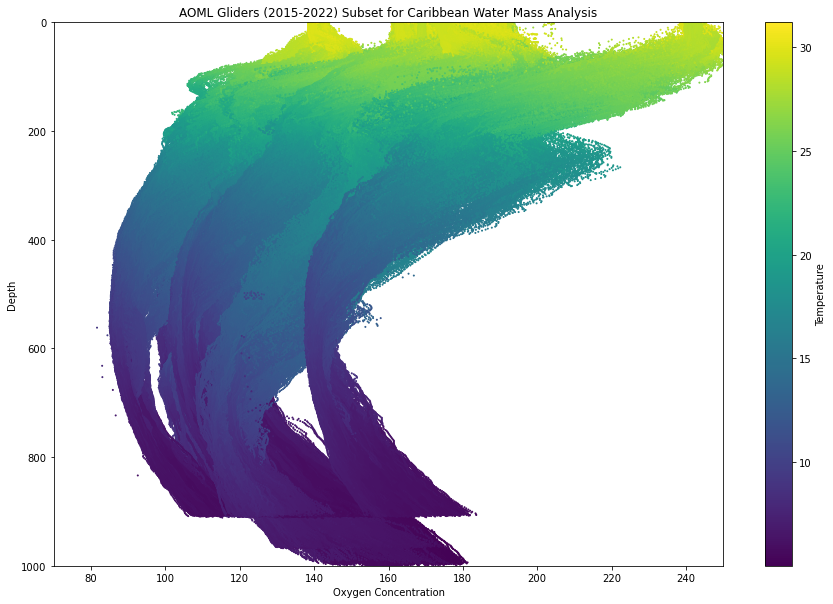

In [8]:
plt.figure(figsize=(15,10))
plt.scatter(tot_transect_df.aanderaa4831_dissolved_oxygen_shifted.values,tot_transect_df.ctd_pressure.values,c=tot_transect_df.temperature.values,s=1)
plt.colorbar(label='Temperature')
plt.ylim(1000,0)
plt.xlim(70,250)
plt.xlabel('Oxygen Concentration')
plt.ylabel('Depth')
plt.title('AOML Gliders (2015-2022) Subset for Caribbean Water Mass Analysis')


## Make mean north/south T/S/O2 plots

In [168]:
## Edited this to explicitly give the min and max lat for these plots so the interpolation is across the latitudes of the densest observations

def transect_df_to_transport_ds(df, min_lat, max_lat,lat_grid_dy=0.05, geo_dz=2):
    ## first drop where lon/lat are nan
    df = df[df['latitude'].notna()]

    ## find min and max latitude for lat grid
    #min_lat = df.latitude.values.min()
    #max_lat = df.latitude.values.max()
    min_lon = df.longitude.values.min()
    max_lon = df.longitude.values.max()
    ## make latitude grid
    lat_gridt = np.arange(min_lat, max_lat, lat_grid_dy) 
    ## take the mean longitude for calculating the grid distance
    mean_lon = np.nanmean(df.longitude.values)

    ## this is the grid dy in meters then (0.05 degree latitude grid sizing is ~5.5 km)
    #dy = dist_from_lat_lon(lat_gridt[0],mean_lon,lat_gridt[1],mean_lon)
    ## this is the grid dy in meters, actually using the "angle" of the transect by using the true start and end lon
    ## (keep checking if 0.05 degree latitude grid sizing is ~5.8 km)
    dy = dist_from_lat_lon(min_lat,min_lon,max_lat,max_lon)/len(lat_gridt)
    transect_dist = dist_from_lat_lon(min_lat,min_lon,max_lat,max_lon)

    ## Now make the vertical (depth) grid
    geo_dz = 2 # meters
    ## for the depth grid just go to the max depth rounded to the nearest geo_dz'th place (i.e. geo_dz = 2, round to 911 m to 912)
    max_depth = round(df.ctd_pressure.max()/2)*2
    depth_gridt = np.arange(0,max_depth,geo_dz)

    ## now turn the temporary 1D grids into a 2D grid
    lat_grid, depth_grid = np.meshgrid(lat_gridt,depth_gridt)
    
    ########## Convert variables for calculations
    ## Absolute salinity
    SA = gsw.SA_from_SP(df.salinity.values, df.ctd_pressure.values, df.longitude.values, df.latitude.values)
    ## Potential temperature
    PT = gsw.pt0_from_t(SA, df.temperature.values, df.ctd_pressure.values)
    ## Conservative temperature
    CT = gsw.CT_from_t(SA, df.temperature.values, df.ctd_pressure.values)
    ## Potential density
    sigma0  = gsw.sigma0(SA,CT)+1000
    ## Specific volume anomaly
    specvol_anom = gsw.specvol_anom_standard(SA, CT, df.ctd_pressure.values)

    ## do the interpolation
    griddensity      = griddata((df.latitude.values,df.ctd_pressure.values), sigma0, (lat_grid, depth_grid), method='linear')
    ## also do it for t,s,O2 because that's what the analysis will eventually focus on
    gridtemperature  = griddata((df.latitude.values,df.ctd_pressure.values), PT, (lat_grid, depth_grid), method='linear')
    gridsalinity     = griddata((df.latitude.values,df.ctd_pressure.values), df.salinity.values, (lat_grid, depth_grid), method='linear')
    gridoxygen       = griddata((df.latitude.values,df.ctd_pressure.values), df.aanderaa4831_dissolved_oxygen_shifted, (lat_grid, depth_grid), method='linear')
    gridspecvol_anom = griddata((df.latitude.values,df.ctd_pressure.values), specvol_anom, (lat_grid, depth_grid), method='linear')
    
    
    pv = np.empty((len(depth_gridt),len(lat_gridt)))
    pv[:] = np.nan
    for x in np.arange(0,len(lat_gridt)):
        pv1 = sw.geostrophic.bfrq(gridsalinity[:,x], gridtemperature[:,x], depth_gridt, lat=np.nanmean(lat_grid))[1]
        ## Because PV takes a derivative and changes the length of the depth variable
        ## take the first point as nan and shift everything else down.
        pv1 = np.insert(pv1, 0, np.nan)
        pv[:,x] = pv1


    ## now get the depth averaged current on this latitude grid
    grid_du = np.empty(len(lat_gridt))
    grid_du[:] = np.nan
    ## also do this for the mean oxygen time shift, not as meaningful but still want to keep track of it
    mean_time_shift = np.empty(len(lat_gridt))
    mean_time_shift[:] = np.nan

    ## Loop to compile DAC in each latitude bin and take mean
    for x in np.arange(0,len(lat_gridt)-1):
        subset_df = df[(df.latitude >= lat_gridt[x]) & (df.latitude <= lat_gridt[x+1])]
        ## Do a quick DAC QAQC, set DAC greater than 10 m/s to nan
        subset_df.du[np.abs(subset_df.du) > 5] = np.nan
        ## take mean DAC in that latitude bin
        grid_du[x] = np.nanmean(subset_df.du.values)
        ## take mean oxygen time shift in that latitude bin
        mean_time_shift[x] = np.nanmean(subset_df.time_shift.values)

    ## Calculate d(rho)/d(y)
    d_rho_dy = np.gradient(griddensity,dy,axis=1)

    ## Calculate d(u)/d(z)
    CF = sw.extras.f(df.latitude.values.mean())
    g = sw.eos80.g(df.latitude.values.mean(), 0)
    therm_wind = (1/CF)*(g/1027)*d_rho_dy

    ## Now integrate d(u)/d(z) vertically to get u
    ## replace nan with zeros for integration
    therm_wind[np.where(np.isnan(therm_wind) ==True)] = 0
    ## flip to integrate from bottom and then flip back
    rel_Vg = integrate.cumtrapz(therm_wind[::-1,:], dx=geo_dz, initial=0, axis=0)[::-1,:]

    ## Now add the reference velocity
    vref = grid_du - np.nanmean(rel_Vg,axis=0)
    Vgeo = rel_Vg + vref

    ## Calculate mid-point time
    start_time = np.nanmin(pd.to_datetime(df.ctd_time[df['ctd_time'].notna()]))
    end_time   = np.nanmax(pd.to_datetime(df.ctd_time[df['ctd_time'].notna()]))
    dt = (end_time-start_time)/2
    mid_time = pd.to_datetime(df.ctd_time.values)[0]+dt

    ## Now save!
    geo_grid_ds = xr.Dataset(
        data_vars=dict(
            Vgeo =(["depth", "latitude"], Vgeo),
            density =(["depth", "latitude"], griddensity),
            temperature =(["depth", "latitude"], gridtemperature),
            salinity =(["depth", "latitude"], gridsalinity),
            oxygen =(["depth", "latitude"], gridoxygen),
            specvol_anom = (["depth","latitude"], gridspecvol_anom),
            pv = (["depth","latitude"], pv),
            mean_time_shift = (["latitude"], mean_time_shift),
            mean_du = (["latitude"],grid_du)),
        coords=dict(
            depth      = depth_gridt,
            latitude   = lat_gridt,
            start_time = start_time,
            end_time   = end_time,
            mid_time   = mid_time,
        ),
        attrs={'description': "Processed geostrophic velocity, temperature, salinity, density, specific volume anomaly, and time shifted oxygen gridded/interpolated onto transect latitude and depth grid",
        'deployment_name': df.deployment_name.values[0],
        'transect_number': df.transect_number.values[0],
        'min_lon': min_lon,
        'max_lon': max_lon,
        'mean_lon': mean_lon,
        'geo_dz': geo_dz,
        'dy': dy,
        'transect_dist': transect_dist}
    )

    return geo_grid_ds


## Mean North and South Transects
This takes ~10 minutes or so

In [169]:
## Because I'm dumb/pandas is dumb
with ChainedAssignent():
    north_transect_ds = transect_df_to_transport_ds(north_transect_df,min_lat=19.5,max_lat=21)
    south_transect_ds = transect_df_to_transport_ds(south_transect_df,min_lat=16,max_lat=17.5)
    

In [164]:
#### THIS WORKS WELL FOR NORTH vs SOUTH MEAN PLOTS


bins = np.arange(0, 1000+5, 5)

temp = north_transect_df.drop(['downs','longitude','latitude','du','dv','su','sv','time_shift','transect_number','deployment_name','aanderaa4831_dissolved_oxygen'],axis=1)
# Create temporary dataframe to interpolate to dz m depths
df_interp = temp.set_index('ctd_pressure')  #set index to depth
df_interp = df_interp[~df_interp.index.duplicated()]  #Remove duplicated indexs (not sure why there would be duplicates)
df_interp = df_interp.reindex(df_interp.index.union(bins))  # reindex to depths in bins
df_interp = df_interp.drop('ctd_time', axis=1).interpolate(method='linear', limit_direction='both')  # drop time and interpolate new depth indexes
df_interp = df_interp.reindex(index=bins)  # only want to see new_index data
north_df_interp = df_interp.reset_index()  # reset index so you can access the depth variable


temp = south_transect_df.drop(['downs','longitude','latitude','du','dv','su','sv','time_shift','transect_number','deployment_name','aanderaa4831_dissolved_oxygen'],axis=1)
# Create temporary dataframe to interpolate to dz m depths
df_interp = temp.set_index('ctd_pressure')  #set index to depth
df_interp = df_interp[~df_interp.index.duplicated()]  #Remove duplicated indexs (not sure why there would be duplicates)
df_interp = df_interp.reindex(df_interp.index.union(bins))  # reindex to depths in bins
df_interp = df_interp.drop('ctd_time', axis=1).interpolate(method='linear', limit_direction='both')  # drop time and interpolate new depth indexes
df_interp = df_interp.reindex(index=bins)  # only want to see new_index data
south_df_interp = df_interp.reset_index()  # reset index so you can access the depth variable


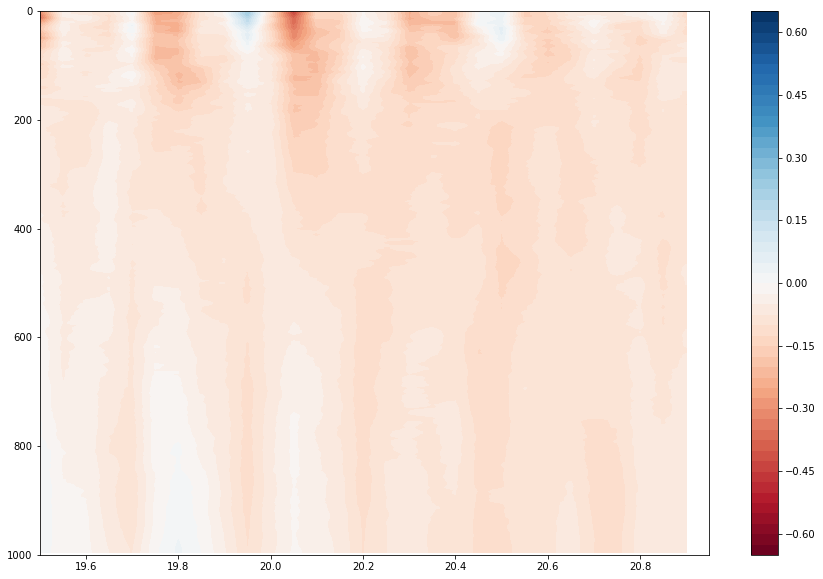

In [170]:
plt.figure(figsize=(15,10))
plt.contourf(north_transect_ds.latitude,north_transect_ds.depth,north_transect_ds.Vgeo,cmap='RdBu',levels=np.arange(-0.65,0.66,0.025))
plt.ylim(1000,0)
plt.colorbar()

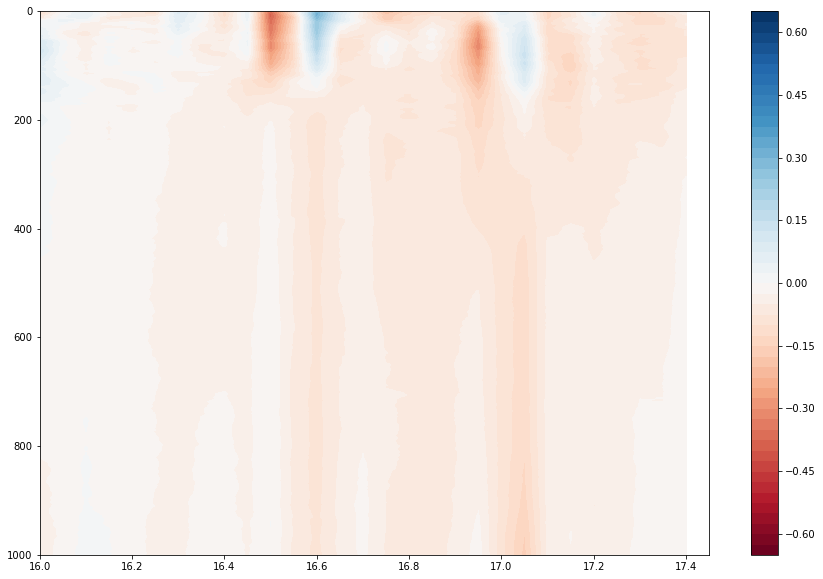

In [171]:
plt.figure(figsize=(15,10))
plt.contourf(south_transect_ds.latitude,south_transect_ds.depth,south_transect_ds.Vgeo,cmap='RdBu',levels=np.arange(-0.65,0.66,0.025))
plt.ylim(1000,0)
plt.colorbar()

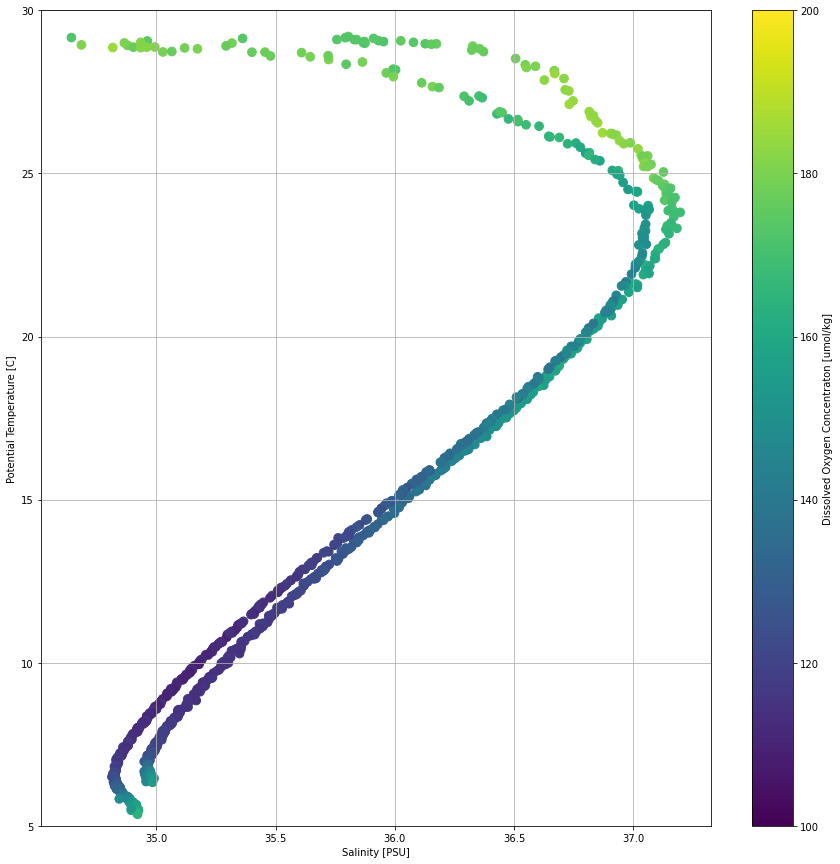

In [172]:
plt.figure(figsize=(15,15))

plt.scatter(north_transect_ds.salinity.mean(axis=1),north_transect_ds.temperature.mean(axis=1),c=north_transect_ds.oxygen.mean(axis=1),s=75,vmin=100,vmax=200)
plt.scatter(south_transect_ds.salinity.mean(axis=1),south_transect_ds.temperature.mean(axis=1),c=south_transect_ds.oxygen.mean(axis=1),s=75,vmin=100,vmax=200)
plt.colorbar(label='Dissolved Oxygen Concentraton [umol/kg]')
plt.ylabel('Potential Temperature [C]')
plt.xlabel('Salinity [PSU]')
plt.ylim(5,30)
plt.grid()

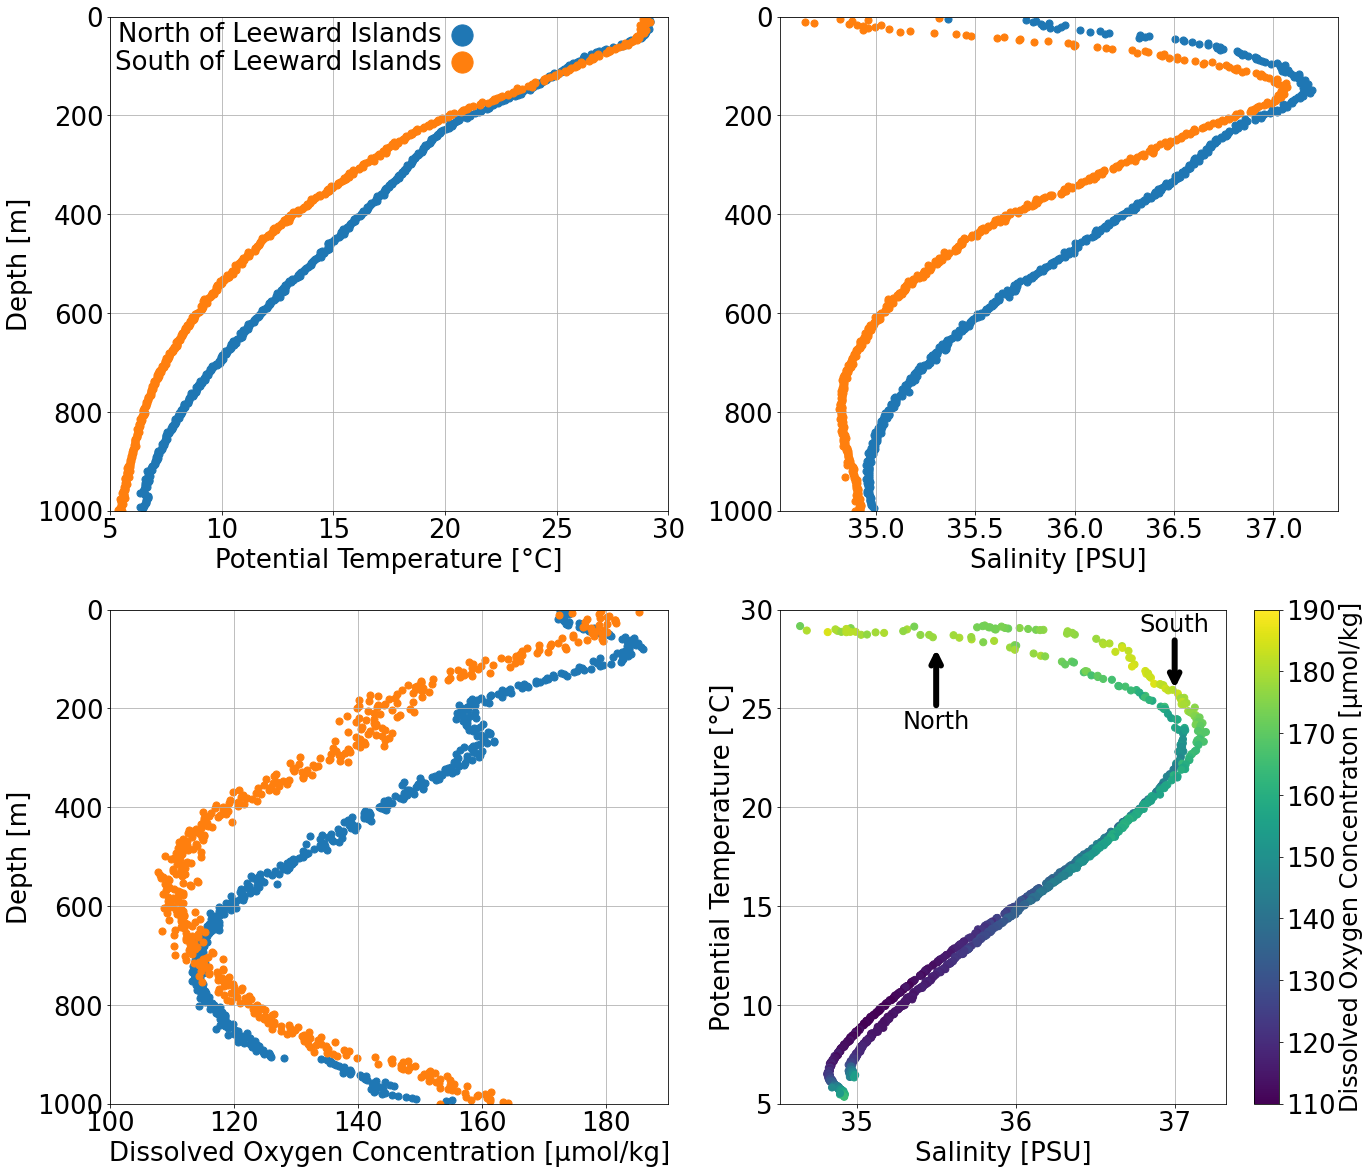

In [174]:
fig, axs = plt.subplots(2, 2, figsize=(22, 20))

font_size = 26


axs[0,0].scatter(north_transect_ds.temperature.mean(axis=1),north_transect_ds.depth,s=50,label='North of Leeward Islands')
axs[0,0].scatter(south_transect_ds.temperature.mean(axis=1),south_transect_ds.depth,s=50,label='South of Leeward Islands')
axs[0,0].set_xlabel('Potential Temperature [°C]',fontsize=font_size)
axs[0,0].set_ylabel('Depth [m]',fontsize=font_size)
axs[0,0].set_ylim(1000,0)
axs[0,0].set_xlim(5,30)
axs[0,0].grid()
axs[0,0].tick_params(axis='both', which='major', labelsize=font_size)
axs[0,0].legend(fontsize=font_size,markerscale=3,frameon=False,markerfirst=False,loc='upper left',handletextpad=-0.25, labelspacing=0.05,borderaxespad=-0.2)


axs[0,1].scatter(north_transect_ds.salinity.mean(axis=1),north_transect_ds.depth,s=50)
axs[0,1].scatter(south_transect_ds.salinity.mean(axis=1),south_transect_ds.depth,s=50)
axs[0,1].set_xlabel('Salinity [PSU]',fontsize=font_size)
axs[0,1].set_ylim(1000,0)
axs[0,1].grid()
axs[0,1].tick_params(axis='both', which='major', labelsize=font_size)


axs[1,0].scatter(north_transect_ds.oxygen.mean(axis=1),north_transect_ds.depth,s=50)
axs[1,0].scatter(south_transect_ds.oxygen.mean(axis=1),south_transect_ds.depth,s=50)
axs[1,0].set_xlabel('Dissolved Oxygen Concentration [μmol/kg]',fontsize=font_size)
axs[1,0].set_ylabel('Depth [m]',fontsize=font_size)
axs[1,0].set_ylim(1000,0)
axs[1,0].set_xlim(100,190)
axs[1,0].grid()
axs[1,0].tick_params(axis='both', which='major', labelsize=font_size)


axs[1,1].scatter(south_transect_ds.salinity.mean(axis=1),south_transect_ds.temperature.mean(axis=1),c=south_transect_ds.oxygen.mean(axis=1),s=50,vmin=110,vmax=190)
plt.annotate(
'South', xy=(37, 25.9),xytext=(37, 28.9) ,
size=24, horizontalalignment="center",
arrowprops=dict(arrowstyle='->',lw=6)
)

stuff = axs[1,1].scatter(north_transect_ds.salinity.mean(axis=1),north_transect_ds.temperature.mean(axis=1),c=north_transect_ds.oxygen.mean(axis=1),s=50,vmin=110,vmax=190)
plt.annotate(
'North', xy=(35.5, 28.1),xytext=(35.5, 24) ,
size=24, horizontalalignment="center",
arrowprops=dict(arrowstyle='->',lw=6)
)

axs[1,1].set_ylabel('Potential Temperature [°C]',fontsize=font_size)
axs[1,1].set_xlabel('Salinity [PSU]',fontsize=font_size)
axs[1,1].set_ylim(5,30)
axs[1,1].grid()
axs[1,1].tick_params(axis='both', which='major', labelsize=font_size)
cbar = fig.colorbar(stuff)
cbar.set_label('Dissolved Oxygen Concentraton [μmol/kg]',size=font_size-2)
cbar.ax.tick_params(labelsize=font_size) 


plt.savefig('/Users/joegradone/Desktop/AOML_North_vs_South_Mean_T_S_O2_Profiles.png', bbox_inches='tight',dpi=300,facecolor='white')

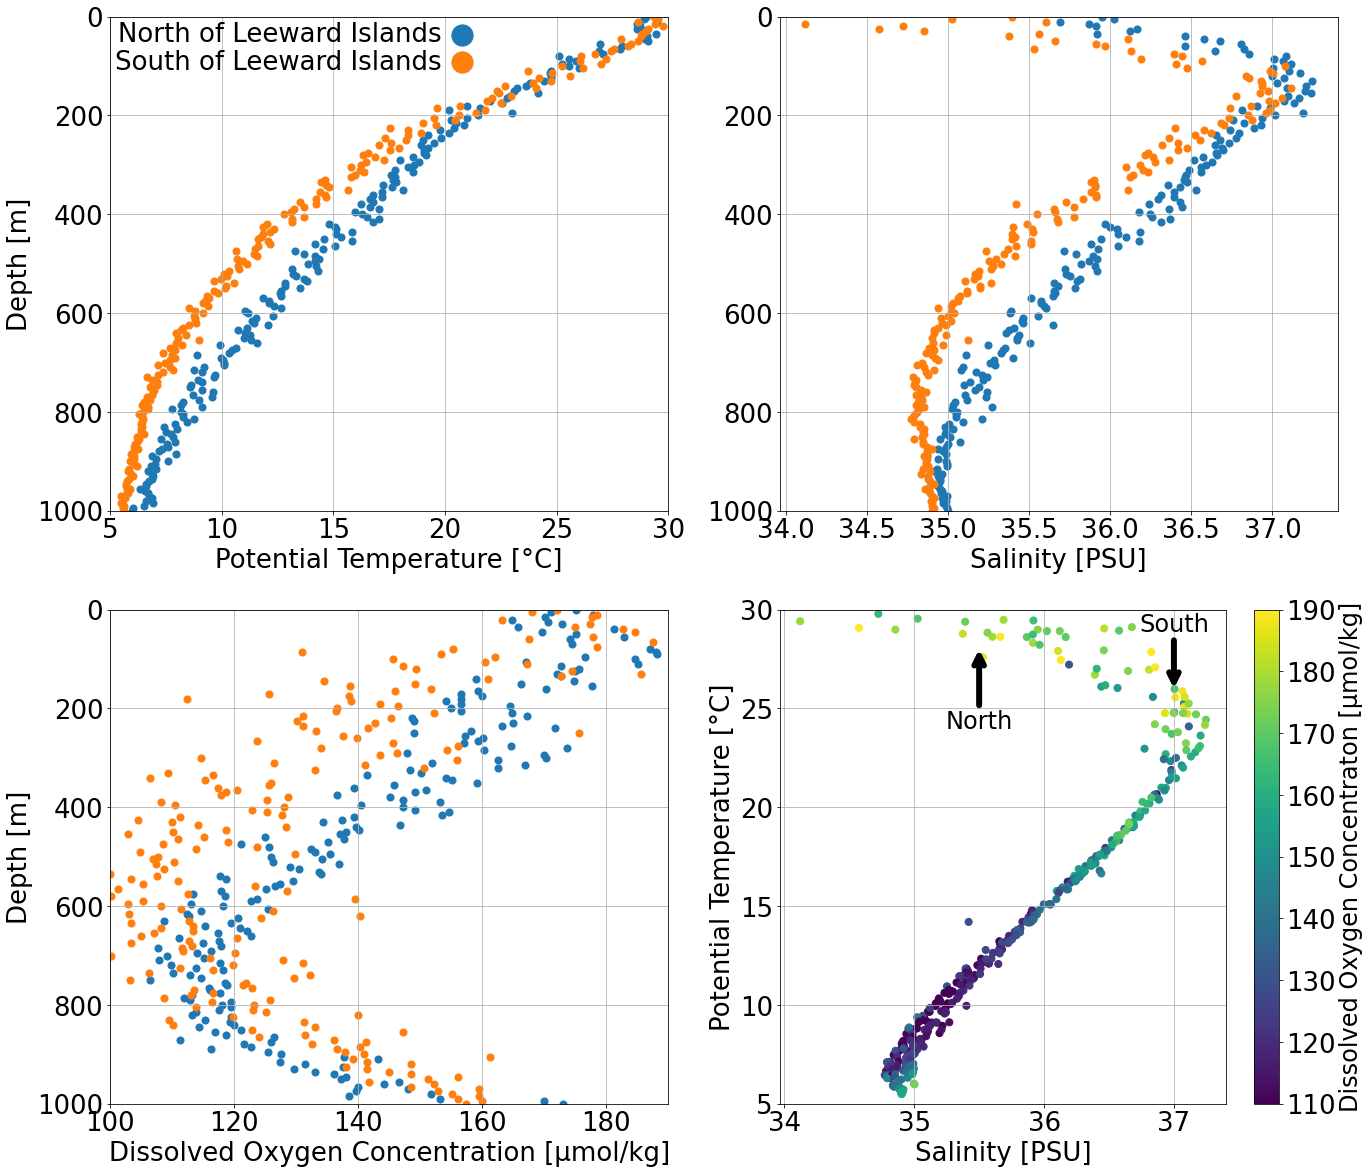

In [165]:
fig, axs = plt.subplots(2, 2, figsize=(22, 20))

font_size = 26


axs[0,0].scatter(north_df_interp.temperature,north_df_interp.ctd_pressure,s=50,label='North of Leeward Islands')
axs[0,0].scatter(south_df_interp.temperature,south_df_interp.ctd_pressure,s=50,label='South of Leeward Islands')
axs[0,0].set_xlabel('Potential Temperature [°C]',fontsize=font_size)
axs[0,0].set_ylabel('Depth [m]',fontsize=font_size)
axs[0,0].set_ylim(1000,0)
axs[0,0].set_xlim(5,30)
axs[0,0].grid()
axs[0,0].tick_params(axis='both', which='major', labelsize=font_size)
axs[0,0].legend(fontsize=font_size,markerscale=3,frameon=False,markerfirst=False,loc='upper left',handletextpad=-0.25, labelspacing=0.05,borderaxespad=-0.2)


axs[0,1].scatter(north_df_interp.salinity,north_df_interp.ctd_pressure,s=50)
axs[0,1].scatter(south_df_interp.salinity,south_df_interp.ctd_pressure,s=50)
axs[0,1].set_xlabel('Salinity [PSU]',fontsize=font_size)
axs[0,1].set_ylim(1000,0)
axs[0,1].grid()
axs[0,1].tick_params(axis='both', which='major', labelsize=font_size)


axs[1,0].scatter(north_df_interp.aanderaa4831_dissolved_oxygen_shifted,north_df_interp.ctd_pressure,s=50)
axs[1,0].scatter(south_df_interp.aanderaa4831_dissolved_oxygen_shifted,south_df_interp.ctd_pressure,s=50)
axs[1,0].set_xlabel('Dissolved Oxygen Concentration [μmol/kg]',fontsize=font_size)
axs[1,0].set_ylabel('Depth [m]',fontsize=font_size)
axs[1,0].set_ylim(1000,0)
axs[1,0].set_xlim(100,190)
axs[1,0].grid()
axs[1,0].tick_params(axis='both', which='major', labelsize=font_size)


axs[1,1].scatter(south_df_interp.salinity,south_df_interp.temperature,c=south_df_interp.aanderaa4831_dissolved_oxygen_shifted,s=50,vmin=110,vmax=190)
plt.annotate(
'South', xy=(37, 25.9),xytext=(37, 28.9) ,
size=24, horizontalalignment="center",
arrowprops=dict(arrowstyle='->',lw=6)
)

stuff = axs[1,1].scatter(north_df_interp.salinity,north_df_interp.temperature,c=north_df_interp.aanderaa4831_dissolved_oxygen_shifted,s=50,vmin=110,vmax=190)
plt.annotate(
'North', xy=(35.5, 28.1),xytext=(35.5, 24) ,
size=24, horizontalalignment="center",
arrowprops=dict(arrowstyle='->',lw=6)
)

axs[1,1].set_ylabel('Potential Temperature [°C]',fontsize=font_size)
axs[1,1].set_xlabel('Salinity [PSU]',fontsize=font_size)
axs[1,1].set_ylim(5,30)
axs[1,1].grid()
axs[1,1].tick_params(axis='both', which='major', labelsize=font_size)
cbar = fig.colorbar(stuff)
cbar.set_label('Dissolved Oxygen Concentraton [μmol/kg]',size=font_size-2)
cbar.ax.tick_params(labelsize=font_size) 


#plt.savefig('/Users/joegradone/Desktop/AOML_North_vs_South_Mean_T_S_O2_Profiles.png', bbox_inches='tight',dpi=300,facecolor='white')

## Now make some plots with the transport data

### Just "normal" north versus south transport

In [10]:
transport_files = sorted(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/Processed_Transport/*'))

transport_north = np.empty(len(transport_files))
transport_north[:] = np.nan
transport_north_tm = np.empty(len(transport_files),dtype='datetime64[s]')

transport_south = np.empty(len(transport_files))
transport_south[:] = np.nan
transport_south_tm = np.empty(len(transport_files),dtype='datetime64[s]')


for x in np.arange(2,len(transport_files)):
    ds = xr.open_dataset(transport_files[x])
    if ds.latitude.mean() > 18.35:
        transport_north[x] = np.nansum(ds.Vgeo.values*ds.attrs['geo_dz']*ds.attrs['dy'])/(10**6)
        transport_north_tm[x] = ds.mid_time.values
        ds.close()
    else:
        transport_south[x] = np.nansum(ds.Vgeo.values*ds.attrs['geo_dz']*ds.attrs['dy'])/(10**6)
        transport_south_tm[x] = ds.mid_time.values
        ds.close()



In [11]:
np.nanmean(transport_south)

-5.186056008830511

In [12]:
np.nanmean(transport_north)

-12.12187242729278

(-30.0, 30.0)

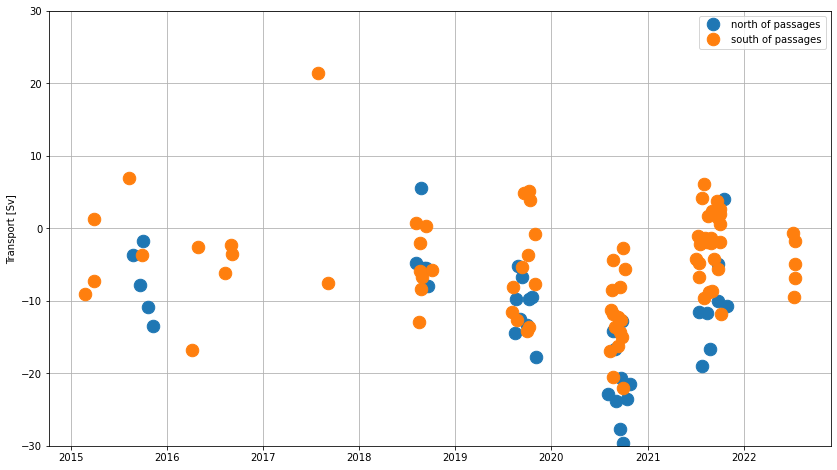

In [13]:
plt.figure(figsize=(14,8))
plt.plot(transport_north_tm,transport_north,'.',label='north of passages',markersize=25)
plt.plot(transport_south_tm,transport_south,'.',label='south of passages',markersize=25)
plt.legend()
plt.grid()
plt.ylabel('Transport [Sv]')
plt.ylim(-30,30)


### Now transport standardized *per* transect length

In [14]:
transport_files = sorted(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/Processed_Transport/*'))

transport_north = np.empty(len(transport_files))
transport_north[:] = np.nan
transport_north_tm = np.empty(len(transport_files),dtype='datetime64[s]')

transport_south = np.empty(len(transport_files))
transport_south[:] = np.nan
transport_south_tm = np.empty(len(transport_files),dtype='datetime64[s]')


for x in np.arange(2,len(transport_files)):
    ds = xr.open_dataset(transport_files[x])
    if ds.latitude.mean() > 18.35:
        transport_north[x] = (np.nansum(ds.Vgeo.values*ds.attrs['geo_dz']*ds.attrs['dy'])/(10**6))/ds.attrs['transect_dist']
        transport_north_tm[x] = ds.mid_time.values
        ds.close()
    else:
        transport_south[x] = (np.nansum(ds.Vgeo.values*ds.attrs['geo_dz']*ds.attrs['dy'])/(10**6))/ds.attrs['transect_dist']
        transport_south_tm[x] = ds.mid_time.values
        ds.close()



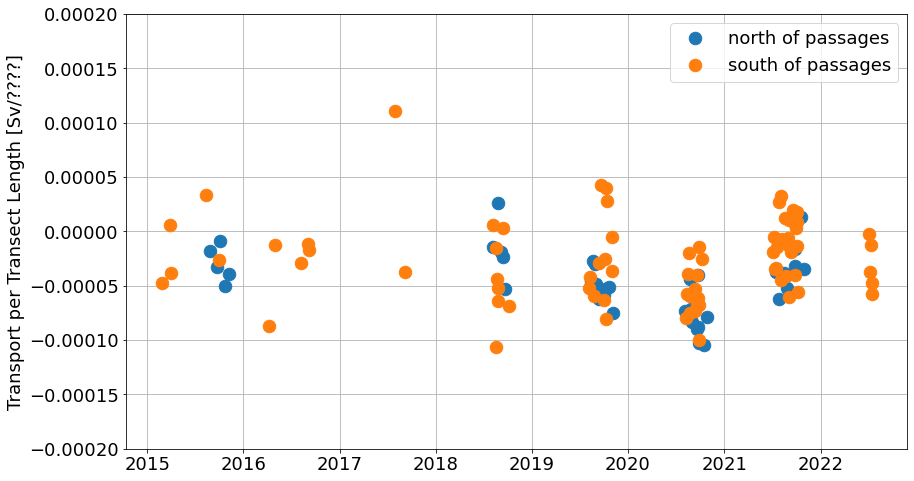

In [15]:
plt.figure(figsize=(14,8))
plt.plot(transport_north_tm,transport_north,'.',label='north of passages',markersize=25)
plt.plot(transport_south_tm,transport_south,'.',label='south of passages',markersize=25)
plt.legend(prop={'size': 18})
plt.grid()
plt.ylabel('Transport per Transect Length [Sv/????]',size=18)
plt.ylim(-0.0002,0.0002)
plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)
#plot.legend(loc=2, prop={'size': 6})



### Now transport across a specified latitude from north and south

In [16]:
transport_files = sorted(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/Processed_Transport/*'))

transport_north = np.empty(len(transport_files))
transport_north[:] = np.nan
transport_north_tm = np.empty(len(transport_files),dtype='datetime64[s]')

transport_south = np.empty(len(transport_files))
transport_south[:] = np.nan
transport_south_tm = np.empty(len(transport_files),dtype='datetime64[s]')


for x in np.arange(2,len(transport_files)):
    ds = xr.open_dataset(transport_files[x])
    if ds.latitude.mean() > 18.35:
        subset_ds = ds.sel(latitude=slice(19.85,20.15))
        transport_north[x] = np.nansum(subset_ds.Vgeo.values*subset_ds.attrs['geo_dz']*subset_ds.attrs['dy'])/(10**6)
        transport_north_tm[x] = ds.mid_time.values
        ds.close()
    else:
        subset_ds = ds.sel(latitude=slice(16.85,17.15))
        transport_south[x] = np.nansum(subset_ds.Vgeo.values*subset_ds.attrs['geo_dz']*subset_ds.attrs['dy'])/(10**6)        
        transport_south_tm[x] = ds.mid_time.values
        ds.close()

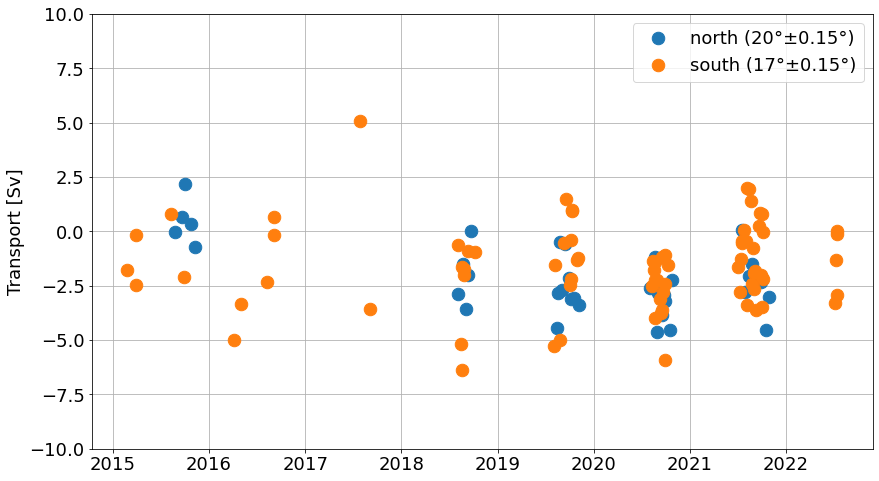

In [17]:
plt.figure(figsize=(14,8))
plt.plot(transport_north_tm,transport_north,'.',label='north (20°±0.15°)',markersize=25)
plt.plot(transport_south_tm,transport_south,'.',label='south (17°±0.15°)',markersize=25)
plt.legend(prop={'size': 18})
plt.grid()
plt.ylabel('Transport [Sv]',size=18)
plt.ylim(-10,10)
plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)



### Then integrate transport vertically and plot horizontal vectors from each transect on a map

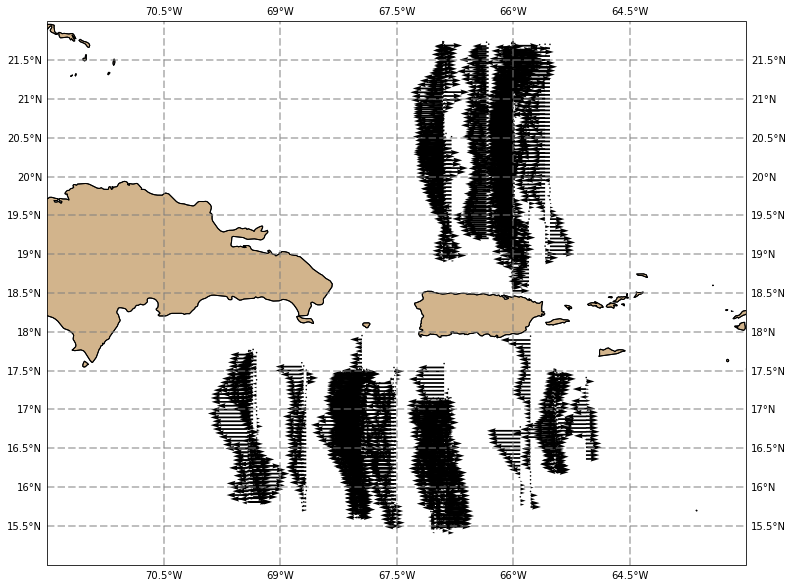

In [18]:
## Map extent
lon1 = -72
lon2 = -63
lat1 = 15
lat2 = 22

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([lon1, lon2, lat1, lat2])
LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor='tan'
)
ax.add_feature(LAND, zorder=0)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.ylocator = mticker.FixedLocator([15.5, 16, 16.5, 17, 17.5, 18, 18.5, 19, 19.5, 20, 20.5, 21, 21.5])


## Now add to plot
transport_files = sorted(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/Processed_Transport/*'))

for x in np.arange(2,len(transport_files)):
    ds = xr.open_dataset(transport_files[x])
    lat_transports = (np.nansum(ds.Vgeo.values,axis=0)*ds.attrs['dy'])/(10**6)
    ax.quiver(np.repeat(ds.attrs['mean_lon'],len(ds.latitude.values)),ds.latitude.values,lat_transports,np.repeat(0,len(ds.latitude.values)),scale=1,width=0.0025, scale_units='inches',transform=ccrs.PlateCarree())
    ds.close()

